In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 
from glob import glob

from pathlib import Path

import cv2
from PIL import Image


In [15]:
TRAIN_IMG_DIR = os.path.join(Path.cwd(), "data", "train_images")
TRAIN_MASK_DIR = os.path.join(Path.cwd(), "data", "train_masks")
VAL_IMG_DIR = os.path.join(Path.cwd(), "data", "val_images")
VAL_MASK_DIR = os.path.join(Path.cwd(), "data", "val_masks")

TEST_IMG_DIR = os.path.join(Path.cwd(), "data", "test_images")

TRAIN_MASKS_CSV = os.path.join(Path.cwd(),"data", "train_masks.csv")
METADATA_CSV = os.path.join(Path.cwd(),"data", "metadata.csv")

In [16]:
train_masks_csv = pd.read_csv(TRAIN_MASKS_CSV)
metadata_csv = pd.read_csv(METADATA_CSV)

In [17]:
train_files = glob(os.path.join(TRAIN_IMG_DIR, "*.jpg"))
train_ids = [s[len(TRAIN_IMG_DIR)+1:-4] for s in train_files]

test_files = glob(os.path.join(TEST_IMG_DIR, "*.jpg"))
test_ids = [s[len(TEST_IMG_DIR)+1:-4] for s in test_files]

### Helper functions

In [28]:
def get_filename(image_id, image_type):
    check_dir = False
    if "train" == image_type:
        ext = 'jpg'
        data_path = TRAIN_IMG_DIR
        suffix = ''
    elif "train_mask" in image_type:
        ext = 'gif'
        data_path = TRAIN_MASK_DIR
        suffix = '_mask'
    elif "test" in image_type:
        ext = 'jpg'
        data_path = TEST_IMG_DIR
        suffix = ''
    else:
        raise Exception("Image type '%s' is not recognized" % image_type)

    if check_dir and not os.path.exists(data_path):
        os.makedirs(data_path)

    return os.path.join(data_path, "{}{}.{}".format(image_id, suffix, ext))

In [30]:
def get_image_data(image_id, image_type, **kwargs):
    if 'mask' in image_type:
        img = _get_image_data_pil(image_id, image_type, **kwargs)
    else:
        img = _get_image_data_opencv(image_id, image_type, **kwargs)
    return img

def _get_image_data_opencv(image_id, image_type, **kwargs):
    fname = get_filename(image_id, image_type)
    img = cv2.imread(fname)
    assert img is not None, "Failed to read image : %s, %s" % (image_id, image_type)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def _get_image_data_pil(image_id, image_type, return_exif_md=False, return_shape_only=False):
    fname = get_filename(image_id, image_type)
    try:
        img_pil = Image.open(fname)
    except Exception as e:
        assert False, "Failed to read image : %s, %s. Error message: %s" % (image_id, image_type, e)

    if return_shape_only:
        return img_pil.size[::-1] + (len(img_pil.getbands()),)

    img = np.asarray(img_pil)
    assert isinstance(img, np.ndarray), "Open image is not an ndarray. Image id/type : %s, %s" % (image_id, image_type)
    if not return_exif_md:
        return img
    else:
        return img, img_pil._getexif()

### Number of unique cars in all datasets

In [42]:
len(metadata_csv['id'].unique())


6572

### Single car with its corresponding mask

Image shape: (1280, 1918, 3) | image type: uint8 | mask shape: (1280, 1918) | mask type: uint8


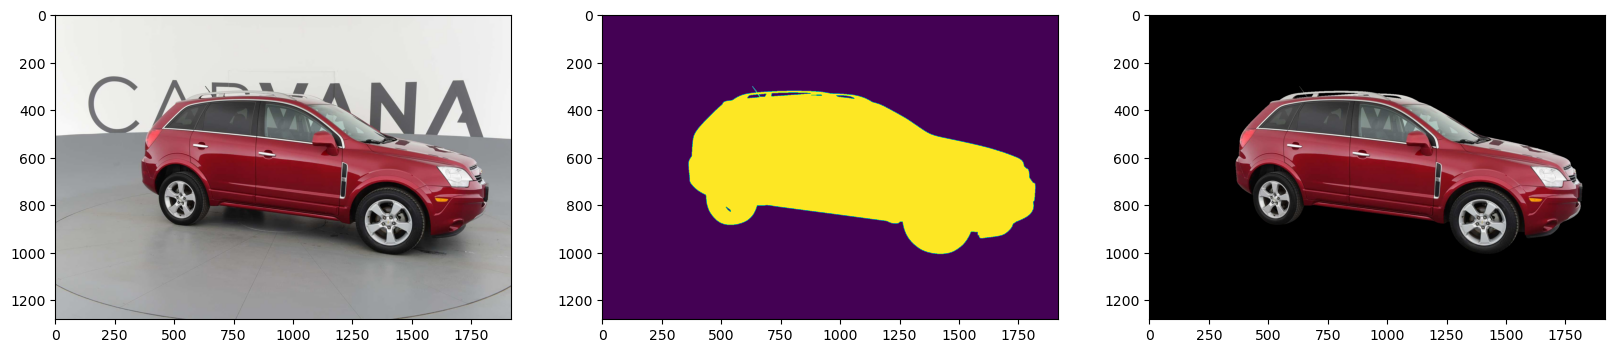

In [32]:
image_id = train_ids[45]

plt.figure(figsize=(20, 20))
img = get_image_data(image_id, "train")
mask = get_image_data(image_id, "train_mask")
img_masked = cv2.bitwise_and(img, img, mask=mask)

print("Image shape: {} | image type: {} | mask shape: {} | mask type: {}".format(img.shape, img.dtype, mask.shape, mask.dtype) )

plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(mask)
plt.subplot(133)
plt.imshow(img_masked)

### Display 100 random cars from training dataset

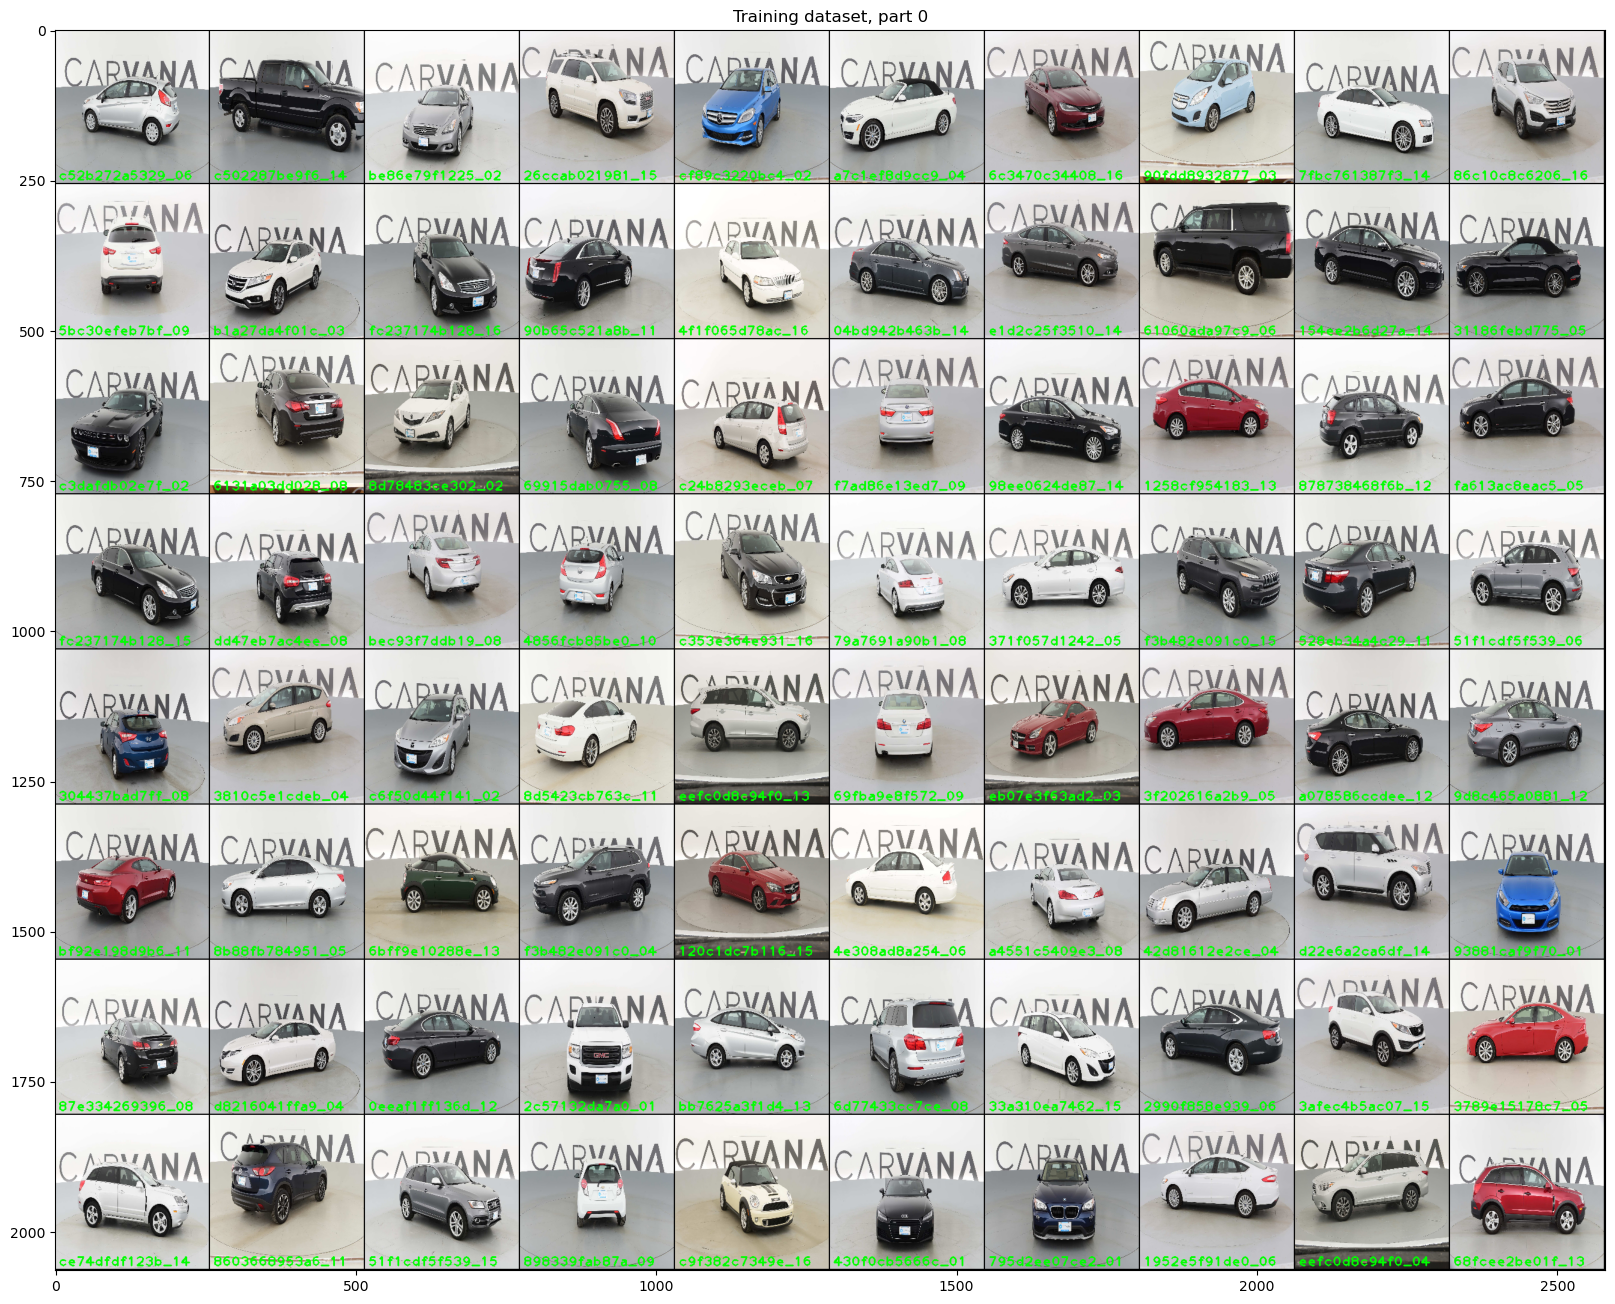

In [37]:
_train_ids = list(train_ids)
np.random.shuffle(_train_ids)
_train_ids = _train_ids[:80]
tile_size = (256, 256)
n = 10

m = int(np.ceil(len(_train_ids) * 1.0 / n))
complete_image = np.zeros((m*(tile_size[0]+2), n*(tile_size[1]+2), 3), dtype=np.uint8)

counter = 0
for i in range(m):
    ys = i*(tile_size[1] + 2)
    ye = ys + tile_size[1]
    for j in range(n):
        xs = j*(tile_size[0] + 2)
        xe = xs + tile_size[0]
        if counter == len(_train_ids):
            break
        image_id = _train_ids[counter]; counter+=1
        img = get_image_data(image_id, 'train')
        img = cv2.resize(img, dsize=tile_size)
        img = cv2.putText(img, image_id, (5,img.shape[0] - 5), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 255, 0), thickness=2)
        complete_image[ys:ye, xs:xe, :] = img[:,:,:]
    if counter == len(_train_ids):
        break    
m = complete_image.shape[0] / (tile_size[0] + 2)
k = 8
n = int(np.ceil(m / k))
for i in range(n):
    plt.figure(figsize=(20, 20))
    ys = i*(tile_size[0] + 2)*k
    ye = min((i+1)*(tile_size[0] + 2)*k, complete_image.shape[0])
    plt.imshow(complete_image[ys:ye,:,:])
    plt.title("Training dataset, part %i" % i)

### Number of cars in training dataset

In [46]:
train_masks_csv['id'] = train_masks_csv['img'].apply(lambda x: x[:-7])

print('Number of unique cars in train dataset:', len(train_masks_csv['id'].unique()))
print('Number of total cars in train dataset:', len(train_masks_csv['id'].unique()) * 16)

Number of unique cars in train dataset: 318
Number of total cars in train dataset: 5088


In [48]:
unique_cars_ids = train_masks_csv['id'].unique()

### Display each unique car from train dataset at an angle 

In [61]:
unique_cars_angle_ids = [_id + '_16' for _id in unique_cars_ids]
len(unique_cars_angle_ids)

318

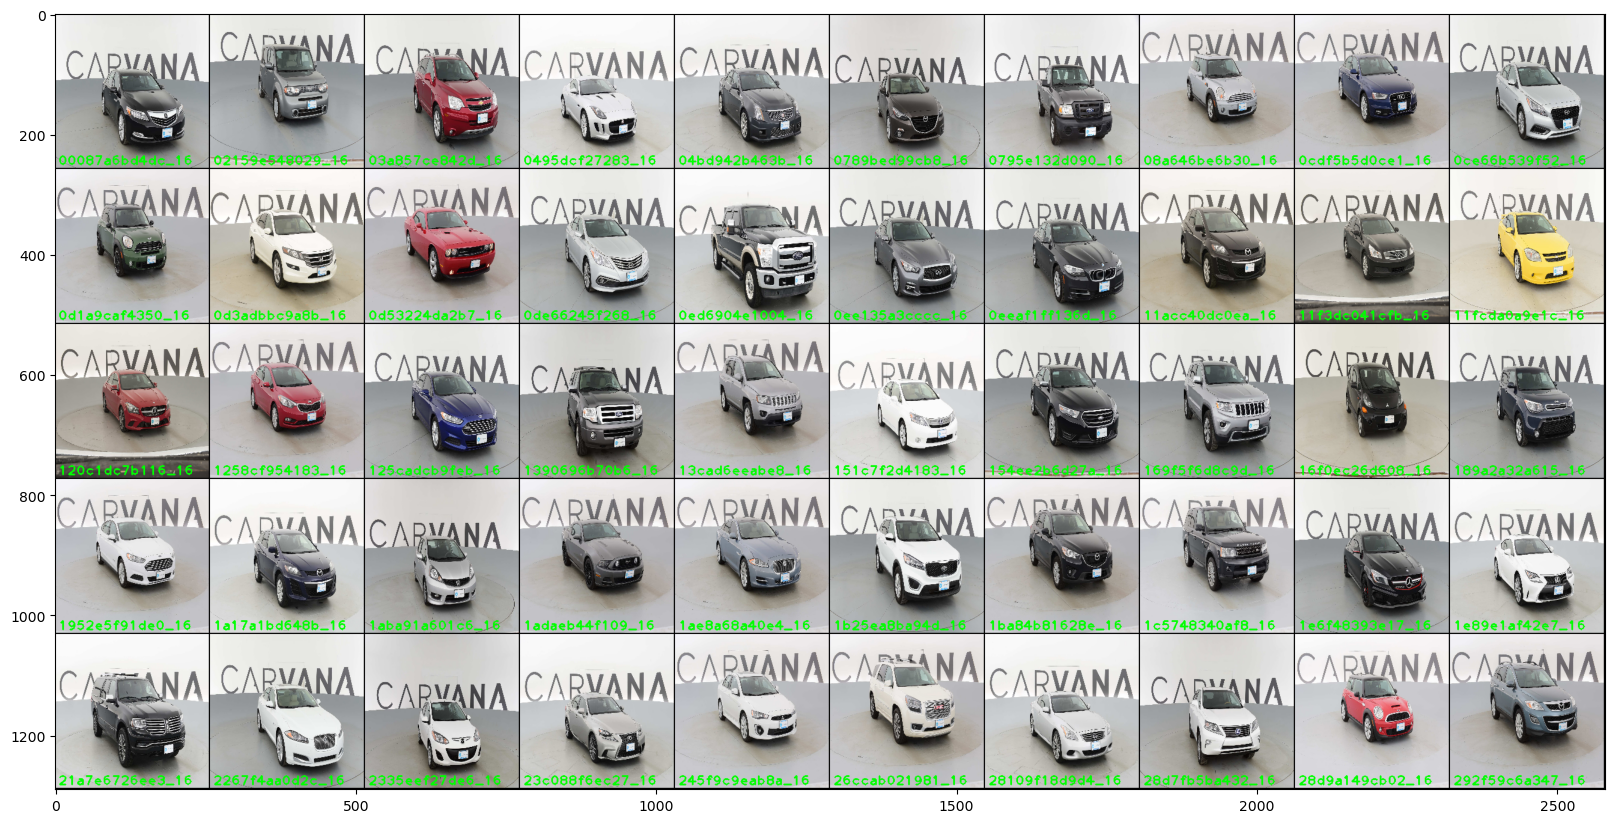

In [65]:
_train_ids_angle = list(unique_cars_angle_ids)
#np.random.shuffle(_train_ids_angle)
_train_ids_angle = _train_ids_angle[:50]

tile_size = (256, 256)
n = 10

m = int(np.ceil(len(_train_ids_angle) * 1.0 / n))
complete_image = np.zeros((m*(tile_size[0]+2), n*(tile_size[1]+2), 3), dtype=np.uint8)

counter = 0
for i in range(m):
    ys = i*(tile_size[1] + 2)
    ye = ys + tile_size[1]
    for j in range(n):
        xs = j*(tile_size[0] + 2)
        xe = xs + tile_size[0]
        if counter == len(_train_ids_angle):
            break
        image_id = _train_ids_angle[counter]; counter+=1
        img = get_image_data(image_id, 'train')
        img = cv2.resize(img, dsize=tile_size)
        img = cv2.putText(img, image_id, (5,img.shape[0] - 5), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 255, 0), thickness=2)
        complete_image[ys:ye, xs:xe, :] = img[:,:,:]
    if counter == len(_train_ids_angle):
        break   
m = complete_image.shape[0] / (tile_size[0] + 2)
k = 8
n = int(np.ceil(m / k))
for i in range(n):
    plt.figure(figsize=(20, 20))
    ys = i*(tile_size[0] + 2)*k
    ye = min((i+1)*(tile_size[0] + 2)*k, complete_image.shape[0])
    plt.imshow(complete_image[ys:ye,:,:])

### Which cars are present in the train dataset

In [59]:
metadata_csv.index = metadata_csv['id']
train_metadata_csv = metadata_csv.loc[train_masks_csv['id'].unique(),:]